<center><img src="https://drive.google.com/uc?export=view&id=1ygAs8EMNlIim2ypwmvQn9yN1LbY3hWHV" alt="Drawing"  width="35%"/><center>

# <center><strong>Semantic segmentation baseline</strong></center>
<br/>

<br/><center>This notebook allows you to re-create the baseline results proposed in the **FLAIR-one challenge**.<br/>The code bellow works with the toy dataset (subset) provided in the starting-kit alongside this notebook as well as with the full FLAIR-one dataset accessible after registration to the competition.</center> <br/><br/> 
    
<hr style="height:2px;border-width:0;color:red;background-color:red"> 
    
<center>Before starting this notebook, be sure to read the <font color='red'><b>README.md</b></font> file part of the starting-kit.<br/>It countains information necesary for being able to run this notebook smoothly (requirements and file access).<br/><br/>
We also strongly advise you to read the data technical description provided in the <font color='#D7881C'><em>FLAIR-one_dataset.pdf</em></font> file.</center>
    

<hr style="height:2.5px;border-width:0;color:red;background-color:red"> 
<br/> <br/> 



The notebook is composed of two parts :<br/> 
>(1) <font color='#90c149'><b>data vizualisation</b></font>, allowing you to display some samples and get familiar with the inputs;<br/> 
>(2) the <font color='#90c149'><b>deep-learning framework baseline</b></font> relying on a U-Net architecture.
   

<br/><br/><br/><br/>

------  If you are using <font color='#90c149'><b>Colab</b></font>, make sure to <font color='#90c149'>run the following cell</font>.  ------ <br>

In [2]:
!nvidia-smi

Wed Dec 28 16:43:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.56.06    Driver Version: 520.56.06    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  Off  | 00000000:27:00.0 Off |                    0 |
| N/A   36C    P0    44W / 250W |      2MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-PCI...  Off  | 00000000:A3:00.0 Off |                    0 |
| N/A   

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

<br/><br/><br/><br/><br/><br/><br/>

# <font color='red'>PART-1: Data vizualisation</font>

First, let's import relevant functions from the <font color='#D7881C'><em>data_display.py</em></font> file. 
<br/>

In [3]:
from pathlib import Path
from py_module.data_display import get_data_paths, display_nomenclature, display_samples, display_all_with_semantic_class, display_all

## <font color='#90c149'>Nomenclatures</font>

<br/><hr>

Next, we display the semantic land-cover classes used in the FLAIR-one datatset. You will see that <font color='#90c149'>two nomenclatures are available </font> : 
<ul>
    <li>the <strong><font color='#90c149'>full nomenclature</font></strong> corresponds to the semantic classes used by experts in photo-interpretation to label the pixels of the ground-truth images.</li>
    <li>the <font color='#90c149'><b>main (baseline) nomenclature</b></font> is a simplified version of the full nomenclature. It regroups (into the class 'other') classes that are either strongly under-represented or irrelevant to this challenge.</li>
</ul>        
See the associated <font color='#D7881C'><em>FLAIR-one_dataset.pdf</em></font> for additionnal details on these nomenclatures.<br/><br/>

<font color='#90c149'>Note:</font> in the data exploration part, we employ the full nomenclature. For the second part related to the challenge baseline, the main nomenclature is used. <br/><hr><br/> 

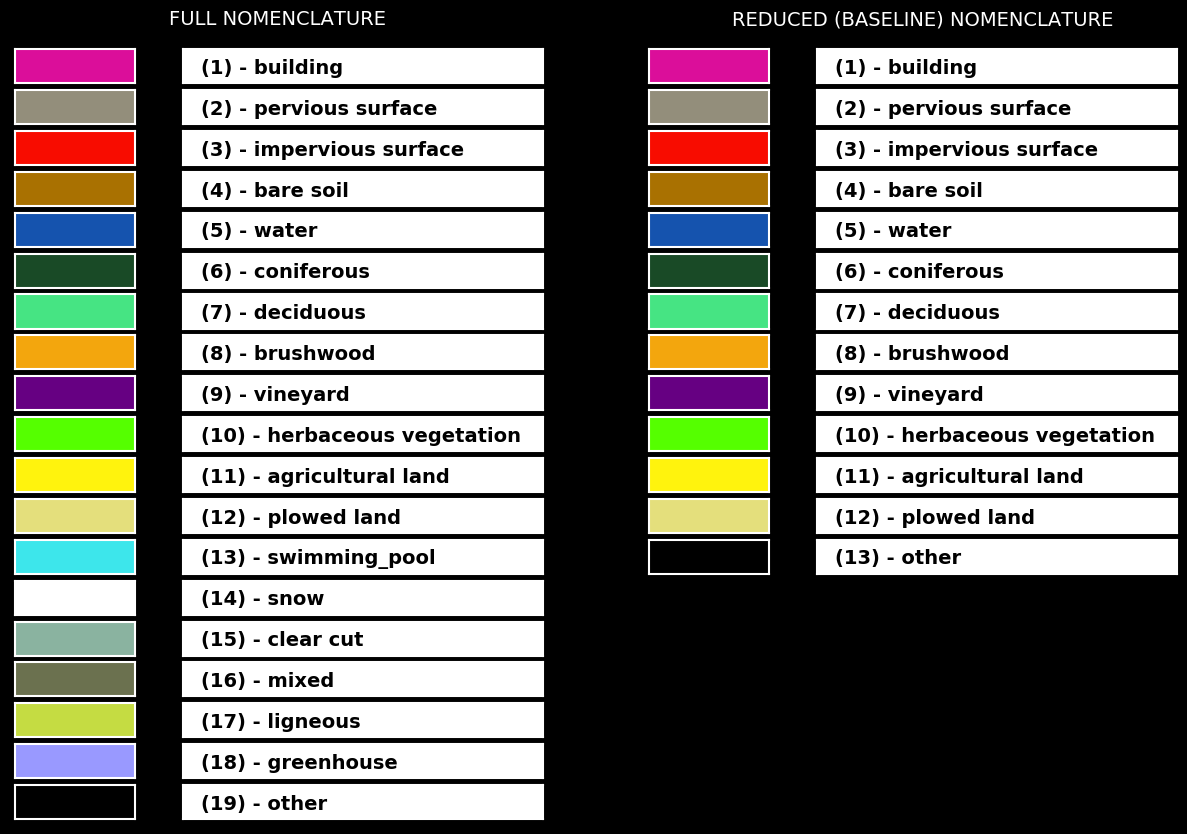

In [4]:
display_nomenclature()

## <font color='#90c149'>Data display</font>

<br/><hr>

We start by creating lists containing the paths to the input images (`images`) and supervision masks (`masks`) files of the dataset.<hr><br/>

In [5]:
path_toy_data = './toy_dataset_flair-one/'

images = sorted(list(get_data_paths(Path(path_toy_data,'train'), 'IMG*.tif')), key=lambda x: int(x.split('_')[-1][:-4]))
masks  = sorted(list(get_data_paths(Path(path_toy_data,'train'), 'MSK*.tif')), key=lambda x: int(x.split('_')[-1][:-4]))

<br/><hr>

Let's display some random samples of IMG-MSK pairs. <font color='#90c149'>Re-run the cell bellow for a different batch.</font><hr><br/>

In [31]:
## Imports
import os
import re
import random
from pathlib import Path
import numpy as np
import matplotlib
from matplotlib.colors import hex2color
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import rasterio
import rasterio.plot as plot

lut_colors = {
1   : '#db0e9a',
2   : '#938e7b',
3   : '#f80c00',
4   : '#a97101',
5   : '#1553ae',
6   : '#194a26',
7   : '#46e483',
8   : '#f3a60d',
9   : '#660082',
10  : '#55ff00',
11  : '#fff30d',
12  : '#e4df7c',
13  : '#3de6eb',
14  : '#ffffff',
15  : '#8ab3a0',
16  : '#6b714f',
17  : '#c5dc42',
18  : '#9999ff',
19  : '#000000'}

lut_classes = {
1   : 'building',
2   : 'pervious surface',
3   : 'impervious surface',
4   : 'bare soil',
5   : 'water',
6   : 'coniferous',
7   : 'deciduous',
8   : 'brushwood',
9   : 'vineyard',
10  : 'herbaceous vegetation',
11  : 'agricultural land',
12  : 'plowed land',
13  : 'swimming_pool',
14  : 'snow',
15  : 'clear cut',
16  : 'mixed',
17  : 'ligneous',
18  : 'greenhouse',
19  : 'other'}

## Functions

def get_data_paths (path, filter):
    for path in Path(path).rglob(filter):
         yield path.resolve().as_posix()


def remapping(lut: dict, recover='color') -> dict:
    rem = lut.copy()
    for idx in [13,14,15,16,17,18,19]: del rem[idx]
    if recover == 'color':  rem[13] = '#000000'
    elif recover == 'class':  rem[13] = 'other'
    return rem
    
def convert_to_color(arr_2d: np.ndarray, palette: dict = lut_colors) -> np.ndarray:
    # print(f'palette : {palette}')
    rgb_palette = {k: tuple(int(i * 255) for i in hex2color(v)) for k, v in palette.items()}
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)
    # print(f'rgb_palette : {rgb_palette}')
    # print(f'arr_2d : {arr_2d}')
    # print(f'arr_2d.shape : {arr_2d.shape}')

    for c, i in rgb_palette.items():
        m = arr_2d == c
        # print(f'c : {c}')
        # print(f'c.shape : {c.shape}')
        arr_3d[m] = i
        # print(f'arr_3d[m]  : {arr_3d[m]}')
    return arr_3d

def display_nomenclature() -> None:   
    GS = matplotlib.gridspec.GridSpec(1,2)
    fig = plt.figure(figsize=(15,10))
    fig.patch.set_facecolor('black')

    plt.figtext(0.73,0.92, "REDUCED (BASELINE) NOMENCLATURE", ha="center", va="top", fontsize=14, color="w")
    plt.figtext(0.3, 0.92, "FULL NOMENCLATURE", ha="center", va="top", fontsize=14, color="w")

    full_nom = matplotlib.gridspec.GridSpecFromSubplotSpec(19, 1, subplot_spec=GS[0])
    for u,k in enumerate(lut_classes):
        curr_gs = matplotlib.gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=full_nom[u], width_ratios=[2,6])
        ax_color, ax_class = fig.add_subplot(curr_gs[0], xticks=[], yticks=[]), fig.add_subplot(curr_gs[1], xticks=[], yticks=[])
        ax_color.set_facecolor(lut_colors[k])
        ax_class.text(0.05,0.3, f'({u+1}) - '+lut_classes[k], fontsize=14, fontweight='bold')
    main_nom = matplotlib.gridspec.GridSpecFromSubplotSpec(19, 1, subplot_spec=GS[1])
    for u,k in enumerate(remapping(lut_classes, recover='class')):
        curr_gs = matplotlib.gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=main_nom[u], width_ratios=[2,6])
        ax_color, ax_class = fig.add_subplot(curr_gs[0], xticks=[], yticks=[]), fig.add_subplot(curr_gs[1], xticks=[], yticks=[])
        ax_color.set_facecolor(remapping(lut_colors, recover='color')[k])
        ax_class.text(0.05,0.3, f'({k}) - '+(remapping(lut_classes, recover='class')[k]), fontsize=14, fontweight='bold')
    for ax in fig.axes:
        for spine in ax.spines.values():
            spine.set_edgecolor('w'), spine.set_linewidth(1.5)
    plt.show()    

def display_samples(images, masks, nb_samples: list, palette=lut_colors) -> None:
    indices= random.sample(range(0, len(images)), nb_samples)
    fig, axs = plt.subplots(nrows = nb_samples, ncols = 3, figsize = (20, nb_samples * 6)); fig.subplots_adjust(wspace=0.0, hspace=0.01)
    fig.patch.set_facecolor('black')
    # print(indices)
    for u, idx in enumerate(indices):
        with rasterio.open(images[idx], 'r') as f:
            im = f.read([1,2,3]).swapaxes(0, 2).swapaxes(0, 1)
        with rasterio.open(masks[idx], 'r') as f:
            mk = f.read([1])
            mk = convert_to_color(mk[0], palette=palette)
        axs = axs if isinstance(axs[u], np.ndarray) else [axs]
        ax0 = axs[u][0] ; ax0.imshow(im);ax0.axis('off')
        ax1 = axs[u][1] ; ax1.imshow(mk, interpolation='nearest') ;ax1.axis('off')
        ax2 = axs[u][2] ; ax2.imshow(im); ax2.imshow(mk, interpolation='nearest', alpha=0.25); ax2.axis('off')
        if u == 0:
            ax0.set_title('RVB Image', size=16,fontweight="bold",c='w')
            ax1.set_title('Ground Truth Mask', size=16,fontweight="bold",c='w')
            ax2.set_title('Overlay Image & Mask', size=16,fontweight="bold",c='w')    

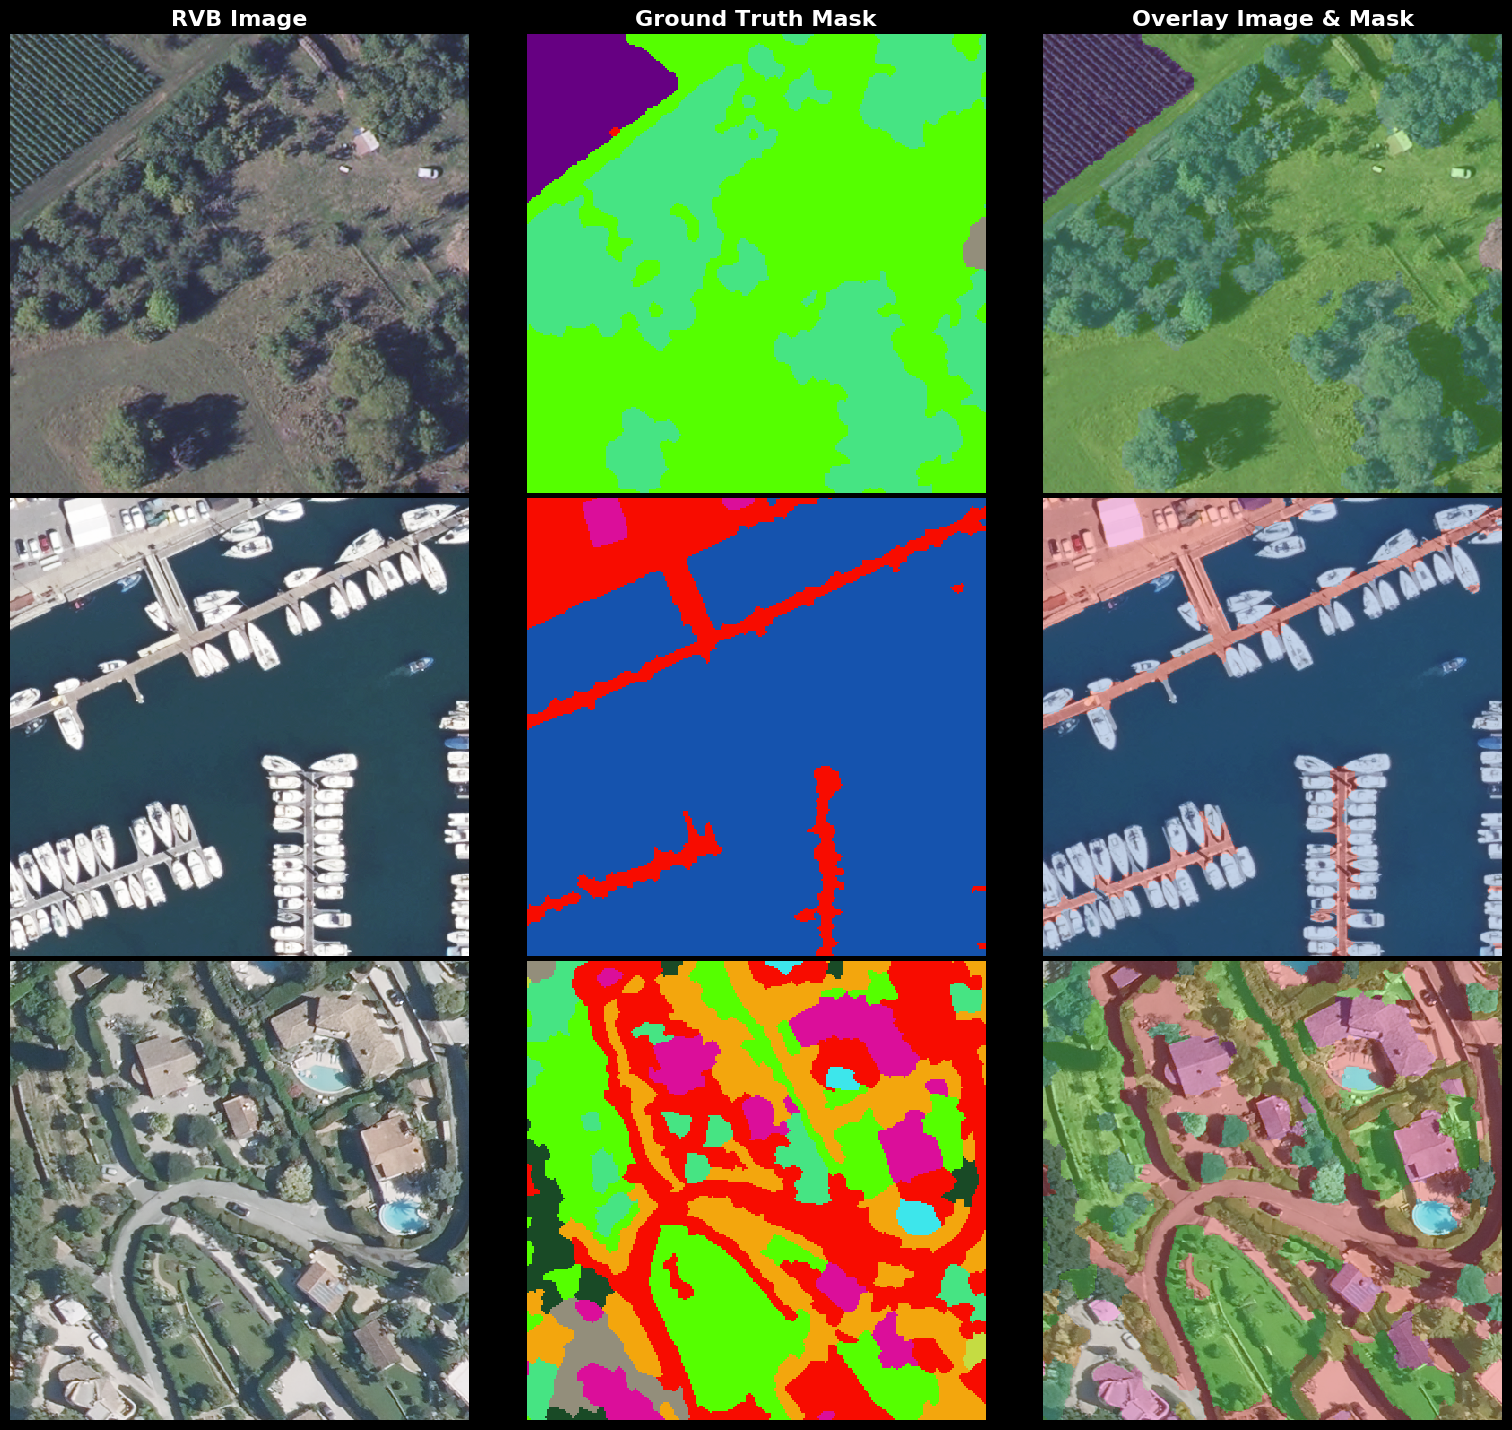

In [32]:
display_samples(images, masks, nb_samples=3)

<br/><hr>

Next let's have a closer look at some specific semantic class.<br/> By setting `semantic_class` to a class number (*e.g.*, `semantic_class`=1 for building or `semantic_class`=5 for water) we can visualize the images containing pixels of this specific class. (the full nomenclature is be used.)<br/>
<font color='#90c149'>Note:</font> for Colab users, this can take some time. <hr><br/>

In [33]:
# display_all_with_semantic_class(images, masks, semantic_class=1)

<br/><hr> 

If working with the toy dataset, we can directly display all images!<br/>
<font color='#90c149'>Note:</font> for Colab users, this can take some time. <hr><br/>

In [34]:
# display_all(images, masks)

<br/><br/><br/><br/><br/><br/><br/><br/><br/>

# <font color='red'>PART-2: Baseline </font>

<br/><hr>

In this second part, we use the toy dataset to train a model similar to the FLAIR-one baseline provided with the challenge.<br/> 
<font color='#90c149'>Note:</font> the presented pipeline can also be applied to the full dataset.

First, let's check if GPU ressources are available in our execution environment. If not, and your are running this notebook in a google colab, select Runtime -> Change runtime type -> select GPU.  If not, and you are running this notebook locally, make sure to set `accelerator = 'cpu'` in the parameters.
<hr><br/>

In [35]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0: print('No GPU found.')
else: print(gpu_info)

Wed Dec 28 18:30:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.56.06    Driver Version: 520.56.06    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  Off  | 00000000:27:00.0 Off |                    0 |
| N/A   35C    P0    57W / 250W |      2MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-PCI...  Off  | 00000000:A3:00.0 Off |                    0 |
| N/A   

<br/><hr>

The cell bellow imports the required libraries, classes and functions, including those provided in the <font color='#D7881C'><em>py-module</em></font> folder provided with this starting-kit. If you are running this notebook on a local environment, make sure all necessary libraries are installed (refer to the <font color='red'>README.md</font> file).

This baseline relies on <font color='#90c149'><em>pytorch-lightning</em></font>, a high-level python framework built on top of Pytorch. It allows multi-GPU training, significantly speeding-up computation of the baseline on the full FLAIR-one dataset. It is however also possible to train on a single GPU as we demonstrate in this notebook.

In this notebook, we also take advantage of the <font color='#90c149'><em>segmentation-models-pytorch</em></font> library, which provides a variery of different pre-trained segmentation models (*e.g.*, U-Net, PSPNet,...).
<hr><br/>

In [11]:
#general 
import os
import numpy as np
import json
import random
from pathlib import Path 


#deep learning
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.callbacks.progress.tqdm_progress import TQDMProgressBar
from pytorch_lightning import Trainer, seed_everything
try:
  from pytorch_lightning.utilities.distributed import rank_zero_only
except ImportError:
  from pytorch_lightning.utilities.rank_zero import rank_zero_only  

import albumentations as A

#flair-one baseline modules 
from py_module.utils import load_data, subset_debug
from py_module.datamodule import OCS_DataModule
# from py_module.model import SMP_Unet_meta
from py_module.task_module import SegmentationTask
from py_module.writer import PredictionWriter

/home/infres/abounhar/flair_challenge_sattelite_image_semantic_segmentation/venv_g6_38/lib64/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## <font color='#90c149'>Task and parameters</font>

<br/><hr>

The toy dataset is composed of $200$ training patches of $512x512$ with corresponding semantic masks, and $50$ test patches. The full dataset contains $61,712$ training patches and $15,700$ testing patches.<br/><br/>

The next cell defines <font color='#90c149'>the paths and hyper-parameters</font>. We recommand starting with the given default values and test if everything is working (check the <font color='#D7881C'><em>FLAIR-one_dataset.pdf</em></font> file for the baseline hyper-parameters). 


The `use_weight` variable enables class-weights during the Cross Entropy loss computation. As the 'other' semantic class is ill-defined, it's weight is set to $0$ as the default strategy.

The `use_metadata` variable enables or disables the use of metadata. If set to `True`, encoded metadata will be added to the architecture's encoder output.

The `use_augmentation` variable enables geometric and radiometric image data augmentations during training. 

See the <font color='#D7881C'><em>FLAIR-one_dataset.pdf</em></font> file for details about the metadata and image data augmentation strategies and the <font color='#D7881C'><em>utils.py</em></font>, <font color='#D7881C'><em>dataset.py</em></font>  and <font color='#D7881C'><em>model.py</em></font> files for implementation. 

<hr><br/>

In [36]:
##############################################################################################
# paths and naming
# path_data = "./toy_dataset_flair-one/" # toy (or full) dataset folder
# path_metadata_file = "./metadata/flair-one_TOY_metadata.json" # json file containing the metadata

path_data = "./dataset/" # toy (or full) dataset folder
path_metadata_file = "./dataset/metadata/flair-one_metadata.json" # json file containing the metadata

out_folder = "./models_output/" # output directory for logs and predictions.
##############################################################################################

##############################################################################################
# tasking
use_weights = True 
class_weights = [1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0]

use_metadata = True
use_augmentation = True
##############################################################################################

##############################################################################################
# training hyper-parameters
batch_size = 16
learning_rate = 2e-2 #0.02
num_epochs = 100
##############################################################################################

##############################################################################################
# computational ressources
accelerator = 'gpu' # set to 'cpu' if GPU not available
gpus_per_node = 1 # set to 1 if mono-GPU
num_nodes = 1 # set to 1 if mono-GPU
strategy = None # Put this parameter to None if train on only one GPU or on CPUs. If multiple GPU, set to 'ddp'
num_workers = 64
##############################################################################################

##############################################################################################
# display
enable_progress_bar = True
progress_rate = 10 #tqdm update rate during training 
##############################################################################################
out_model_name = "unetplusplus_resnet151_lr_"+learning_rate+"_bs_"+batch_size+"_ep_"+num_epochs # to keep track


In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import segmentation_models_pytorch as smp

class mtd_MLP(nn.Module):
    """ 
    Light MLP to encode metadata
    
    """
    def __init__(self):
        super(mtd_MLP, self).__init__()

        self.enc_mlp = nn.Sequential(
            nn.Linear(45, 64),
            nn.Dropout(0.4),
            nn.ReLU(inplace=True),
            nn.Linear(64, 32),
            nn.Dropout(0.4),
            nn.ReLU(inplace=True),
            nn.Linear(32, 16),
            nn.Dropout(0.4),
            nn.ReLU()        
        )            
        
    def forward(self, x):
        x = self.enc_mlp(x)
        return x    



class SMP_Unet_meta(nn.Module):
    """ 
    Pytorch segmentation U-Net with ResNet34 (default) 
    with added metadata information at encoder output
    
    """    
    def __init__(self,
                 n_channels, 
                 n_classes,
                 use_metadata=True,
                 arch="unet",
                 encoder_name="resnet101"
                 ):
        super(SMP_Unet_meta, self).__init__()
        
        self.seg_model = smp.create_model(arch=arch, encoder_name=encoder_name, classes=n_classes, in_channels=n_channels)
        self.use_metadata = use_metadata
        if use_metadata == True:
            self.enc = mtd_MLP()
    
    def forward(self, x, met):
        
        if self.use_metadata == True:
            feats = self.seg_model.encoder(x)
            x_enc = self.enc(met)
            x_enc = x_enc.unsqueeze(1).unsqueeze(-1).repeat(1,2048,1,16)              
            feats[-1] = torch.add(feats[-1], x_enc)     
            output = self.seg_model.decoder(*feats)
            output = self.seg_model.segmentation_head(output)
        else:
            output = self.seg_model(x)

        return output

## <font color='#90c149'>Dataloaders</font>

<br/><hr>

The following cell loads the data into a pytorch-lighning DataModule (`OCS_Datamodule`). If `use_metadata = True` and `use_augmentation = True`, they are also integrated in the DataModule. 

We fix the global seed (python random, torch, numpy) with `seed_eveything`.

`@rank_zero_only` is needed if logging and callbacks are used with multi-GPU processing, preventing synchronization from concurrent processes.

<hr><br/>

In [40]:
out_dir = Path(out_folder, out_model_name)
out_dir.mkdir(parents=True, exist_ok=True)

seed_everything(2022, workers=True)

@rank_zero_only
def step_loading(path_data, path_metadata_file: str, use_metadata: bool) -> dict:
    print('+'+'-'*29+'+', '   LOADING DATA   ', '+'+'-'*29+'+')
    train, val, test = load_data(path_data, path_metadata_file, use_metadata=use_metadata)
    return train, val, test


@rank_zero_only
def print_recap():
    print('\n+'+'='*80+'+',f"{'Model name: '+out_model_name : ^80}", '+'+'='*80+'+', f"{'[---TASKING---]'}", sep='\n')
    for info, val in zip(["use weights", "use metadata", "use augmentation"], [use_weights, use_metadata, use_augmentation]): print(f"- {info:25s}: {'':3s}{val}")
    print('\n+'+'-'*80+'+', f"{'[---DATA SPLIT---]'}", sep='\n')
    for split_name, d in zip(["train", "val", "test"], [dict_train, dict_val, dict_test]): print(f"- {split_name:25s}: {'':3s}{len(d['IMG'])} samples")
    print('\n+'+'-'*80+'+', f"{'[---HYPER-PARAMETERS---]'}", sep='\n')
    for info, val in zip(["batch size", "learning rate", "epochs", "nodes", "GPU per nodes", "accelerator", "workers"], [batch_size, learning_rate, num_epochs, num_nodes, gpus_per_node, accelerator, num_workers]): print(f"- {info:25s}: {'':3s}{val}")        
    print('\n+'+'-'*80+'+', '\n')

dict_train, dict_val, dict_test = step_loading(path_data, path_metadata_file, use_metadata=use_metadata)  
print_recap()



if use_augmentation == True:
    transform_set = A.Compose([A.VerticalFlip(p=0.5),
                               A.HorizontalFlip(p=0.5),
                               A.RandomRotate90(p=0.5)])
else:
    transform_set = None

dm = OCS_DataModule(
    dict_train=dict_train,
    dict_val=dict_val,
    dict_test=dict_test,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=True,
    num_classes=13,
    num_channels=5,
    use_metadata=use_metadata,
    use_augmentations=transform_set)

Global seed set to 2022


+-----------------------------+    LOADING DATA    +-----------------------------+

+================================================================================+
                      Model name: flair-one-baseline_argu                       
+================================================================================+
[---TASKING---]
- use weights              :    True
- use metadata             :    True
- use augmentation         :    True

+--------------------------------------------------------------------------------+
[---DATA SPLIT---]
- train                    :    48865 samples
- val                      :    12847 samples
- test                     :    15700 samples

+--------------------------------------------------------------------------------+
[---HYPER-PARAMETERS---]
- batch size               :    16
- learning rate            :    0.02
- epochs                   :    100
- nodes                    :    1
- GPU per nodes            :    1
- accelerator   

## <font color='#90c149'>Learning setup</font>

<br/><hr>

Next, we define our <font color='#90c149'>model, criterion, optimizer and scheduler</font>.

The model `SMP_Unet_meta` uses a ResNet34 encoder and U-Net decoder implementated in the <em>segmentation-models-pytorch</em> library. If `use_metadata = True`, it adds a custom Multi-layer Perceptron, encoding the metadata.

As criterion, we use the torch implementation of `CrossEntropyLoss`, and as optimizer the Stochastic Gradient Descend (`SGD`).

The pytorch-lighning module `SegmentationTask` organizes and manages the different loops and steps (e.g., training, validation), otherwise manually implemented using torch.

Finally we define `callbacks` (save model checkpoints, stop if learning is stuck with a patience threshold and display progress) as well as a `logger` (tensorboard logs).

<hr><br/>

### Model
<font color='#90c149'>Note:</font> the next cell will trigger the download of ResNet34 (default for U-Net architecture in pytorch-lightning) with pre-trained weights.

In [42]:
model = SMP_Unet_meta(n_channels=5, n_classes=13, use_metadata=False, arch="unetplusplus", encoder_name='resnet152')

In [43]:
model

SMP_Unet_meta(
  (seg_model): UnetPlusPlus(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (

### Loss

In [44]:
if use_weights == True:
    with torch.no_grad():
        class_weights = torch.FloatTensor(class_weights)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
else:
    criterion = nn.CrossEntropyLoss()

### Optimizer

In [45]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### Scheduler

In [46]:
scheduler = ReduceLROnPlateau(
    optimizer=optimizer,
    mode="min",
    factor=0.5,
    patience=10,
    cooldown=4,
    min_lr=1e-7,
)

### Pytorch lightning module

In [47]:
seg_module = SegmentationTask(
    model=model,
    num_classes=dm.num_classes,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    use_metadata=use_metadata
)

### Callbacks

In [48]:
ckpt_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath=os.path.join(out_dir,"checkpoints"),
    filename="ckpt-{epoch:02d}-{val_loss:.2f}"+'_'+out_model_name,
    save_top_k=1,
    mode="min",
    save_weights_only=True, # can be changed accordingly
)

early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.00,
    patience=30, # if no improvement after 30 epoch, stop learning. 
    mode="min",
)

prog_rate = TQDMProgressBar(refresh_rate=progress_rate)

callbacks = [
    ckpt_callback, 
    early_stop_callback,
    prog_rate,
]

### Loggers

In [49]:
logger = TensorBoardLogger(
    save_dir=out_dir,
    name=Path("tensorboard_logs"+'_'+out_model_name).as_posix()
)

loggers = [
    logger
]

## <font color='#90c149'>Launch the training</font>

<br/><hr>

Defining a `Trainer` allows for to automate tasks, such as enabling/disabling grads, running the dataloaders or invoking the callbacks when needed.
<hr><br/>

In [50]:
#### instanciation of  Trainer
trainer = Trainer(
    accelerator=accelerator,
    devices=gpus_per_node,
    strategy=strategy,
    num_nodes=num_nodes,
    max_epochs=num_epochs,
    num_sanity_val_steps=0,
    callbacks = callbacks,
    logger=loggers,
    enable_progress_bar = enable_progress_bar,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


<br/><hr>

<font color='#90c149'>Let's launch the training.</font>
<br/><hr>

In [51]:
trainer.fit(seg_module, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | SMP_Unet_meta    | 83.6 M
1 | criterion     | CrossEntropyLoss | 0     
2 | train_metrics | JaccardIndex     | 0     
3 | val_metrics   | JaccardIndex     | 0     
4 | train_loss    | MeanMetric       | 0     
5 | val_loss      | MeanMetric       | 0     
---------------------------------------------------
83.6 M    Trainable params
0         Non-trainable params
83.6 M    Total params
334.518   Total estimated model params size (MB)


Epoch 0:   4%|▍         | 150/3856 [10:37<4:22:39,  4.25s/it, loss=1.25, v_num=7]

: 

: 

## <font color='#90c149'>Check metrics on the validation dataset</font>

<br/><hr> 

To give an idea on the training results, we call validate on the trainer to print some metrics. <hr><br/>

In [26]:
trainer.validate(seg_module, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Validation DataLoader 0: 100%|██████████| 4/4 [00:13<00:00,  3.42s/it]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            1.1633585691452026
        val_miou            0.4170607924461365
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 1.1633585691452026, 'val_miou': 0.4170607924461365}]

## <font color='#90c149'>Inference and predictions export</font>

<br/><hr>

For inference, we define a new callback, `PredictionWriter`, which is used to export the predictions on the test dataset.<br/><br/>
<font color='#90c149'>Note:</font> the callback exports the files with the mandotary formatting of outputs (files named <font color='red'><b> PRED_{ID].tif</b></font>, with datatype <font color='red'><b>uint8</b></font> and <font color='red'><b>LZW</b></font> compression), using Pillow.
Check the <font color='#D7881C'><em>writer.py</em></font> file for details.<br/><br/>

We instantiate a new `Trainer` with this newly defined callback and call predict.
<hr><br/>

In [27]:
writer_callback = PredictionWriter(        
    output_dir=os.path.join(out_dir, "predictions"+"_"+out_model_name),
    write_interval="batch",
)

#### instanciation of prediction Trainer
trainer = Trainer(
    accelerator=accelerator,
    devices=gpus_per_node,
    strategy=strategy,
    num_nodes=num_nodes,
    callbacks = [writer_callback],
    enable_progress_bar = enable_progress_bar,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [28]:
trainer.predict(seg_module, datamodule=dm)

@rank_zero_only
def print_finish():
    print('--  [FINISHED.]  --', f'output dir : {out_dir}', sep='\n')
print_finish()

Missing logger folder: /home/infres/abounhar/flair_challenge_sattelite_image_semantic_segmentation/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 50/50 [00:05<00:00,  9.72it/s]
--  [FINISHED.]  --
output dir : models_output/flair-one-baseline_argu


## <font color='#90c149'>Visual checking of predictions</font>

<br/><hr>

<font color='#90c149'>For the test set, obviously, you do not have access to the masks.</font> Nevertheless, we can visually display some predictions alongside the RGB images.<br/><br/>

First, we create lists containing the paths to the test RGB images (`images_test`) as well as the predicted semantic segmentation masks (`predictions`).<br/><br/>



We then display some random couples of predictions together with their corresponding aerial RGB images.<br/><br/>

<font color='#90c149'><em>Note 1</em></font>: if you are using the toy dataset, don't expect accurate predictions. A set of $200$ training samples will give limited results.<br/> 
<font color='#90c149'><em>Note 2</em></font>: rasterio will yield a <em>NotGeoreferencedWarning</em> regarding the predictions files. This is normal as the prediction files have been written without any geographical information, which is expected by rasterio. This kind of information is not important for assessing the model outputs, so we can just omit the warning.
<hr><br/>

In [29]:
from py_module.data_display import display_predictions, get_data_paths

images_test = sorted(list(get_data_paths(Path(path_data,'test'), 'IMG*.tif')), key=lambda x: int(x.split('_')[-1][:-4]))
# images_test = sorted(list(get_data_paths(Path(path_data,'train'), 'IMG*.tif')), key=lambda x: int(x.split('_')[-1][:-4]))
predictions = sorted(list(get_data_paths(Path(out_dir, "predictions"+'_'+out_model_name), 'PRED*.tif')), key=lambda x: int(x.split('_')[-1][:-4]))

/home/infres/abounhar/flair_challenge_sattelite_image_semantic_segmentation/venv_g6_38/lib64/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


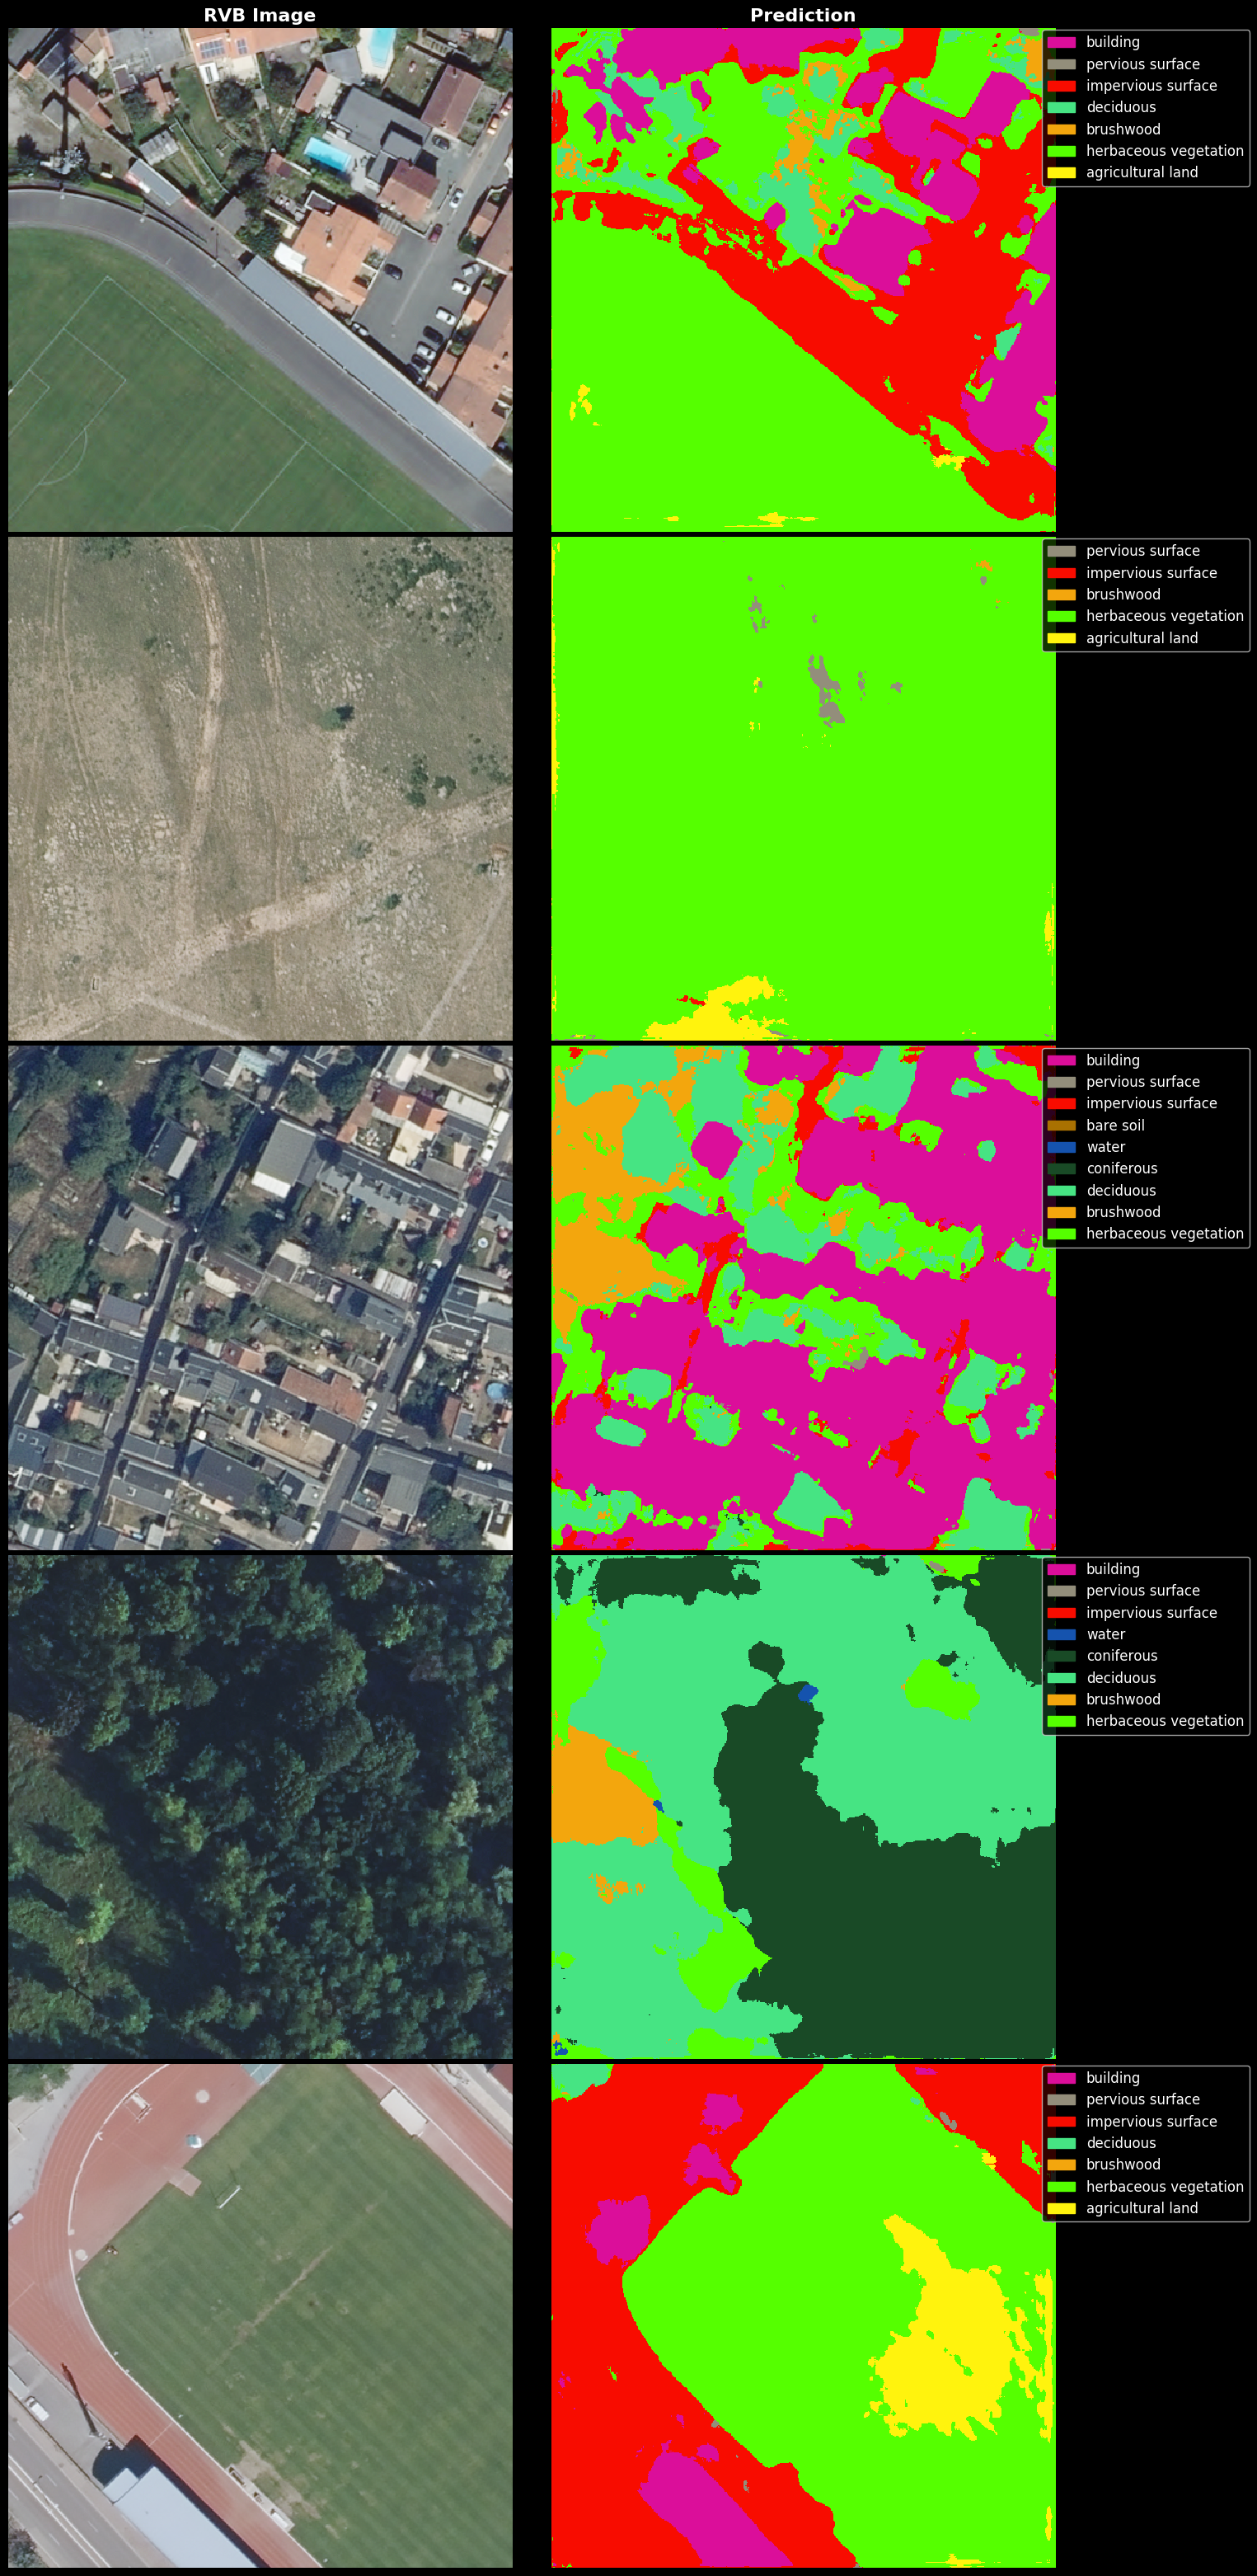

In [30]:
display_predictions(images_test, predictions, nb_samples=5)

## <font color='#90c149'>Metric calculation: mIoU</font>

<br/><hr>

As mentioned before, the masks of the test set are not available. However, the following cell describes the code that is used to calculate the metric used over the test set and to consequently rank the best models. Again, the toy dataset contains $50$ test pastches, while the full FLAIR-one dataset contains $15,700$ test patches.<br/><br/>

The calculation of the mean Intersection-over-Union (`mIou`) is based on the confusion matrix $C$, which is determined for each test patch. The confusion matrices are subsequently summed providing the confusion matrix describing the test set. Per-class IoU, defined as the ratio between true positives divided by the sum of false positives, false negatives and true positives is calculated from the summed confusion matrix as follows: <br/><br/>
    $$
    IoU_i = \frac{C_{i,i}}
    {C_{i,i} + \sum_{j \neq i}\left(C_{i,j} + C_{j,i} \right)} = \frac{TP}{TP+FP+FN}
    $$
<br>
The final `mIou` is then the average of the per-class IoUs. 


<font color='#90c149'><em>Note:</em></font> as the <font color='#90c149'><em>'other'</em></font> class is <font color='#90c149'>not well defined (void)</font>, its IoU is <font color='#90c149'>removed</font> and therefore does not contribute to the calculation of the `mIou`. In other words,  the remaining per-class IoUs (all except 'other') are averaged by 12 and not 13 to obtain the final `mIou`.</font>

<hr><br/>

In [ ]:
import re
import numpy as np
from PIL import Image
from sklearn.metrics import confusion_matrix


def generate_miou(path_truth: str, path_pred: str) -> list:
  
    #################################################################################################
    def get_data_paths (path, filter):
        for path in Path(path).rglob(filter):
             yield path.resolve().as_posix()  
                
    def calc_miou(cm_array):
        m = np.nan
        with np.errstate(divide='ignore', invalid='ignore'):
            ious = np.diag(cm_array) / (cm_array.sum(0) + cm_array.sum(1) - np.diag(cm_array))
        m = np.nansum(ious[:-1]) / (np.logical_not(np.isnan(ious[:-1]))).sum()
        return m.astype(float), ious[:-1]      

    #################################################################################################
                       
    truth_images = sorted(list(get_data_paths(Path(path_truth), 'MSK*.tif')), key=lambda x: int(x.split('_')[-1][:-4]))
    preds_images  = sorted(list(get_data_paths(Path(path_pred), 'PRED*.tif')), key=lambda x: int(x.split('_')[-1][:-4]))
    print('truth images :', len(truth_images))
    print('preds_images images :', len(preds_images))
    if len(truth_images) != len(preds_images): 
        print('[WARNING !] mismatch number of predictions and test files.')
    if truth_images[0][-10:-4] != preds_images[0][-10:-4] or truth_images[-1][-10:-4] != preds_images[-1][-10:-4]: 
        print('[WARNING !] unsorted images and masks found ! Please check filenames.') 
        
    patch_confusion_matrices = []

    for u in range(len(truth_images)):
        target = np.array(Image.open(truth_images[u]))-1 # -1 as model predictions start at 0 and turth at 1.
        target[target>12]=12  ### remapping masks to reduced baseline nomenclature.
        preds = np.array(Image.open(preds_images[u]))         
        patch_confusion_matrices.append(confusion_matrix(target.flatten(), preds.flatten(), labels=list(range(13))))

    sum_confmat = np.sum(patch_confusion_matrices, axis=0)
    mIou, ious = calc_miou(sum_confmat) 

    return mIou, ious


if __name__ == "__main__":  
   truth_msk = './toy_dataset_flair-one/train'
   pred_msk  = './models_output/flair-one-baseline_argu/predictions_flair-one-baseline_argu'
   mIou = generate_miou(truth_msk, pred_msk)

Epoch 0:  20%|██        | 20/100 [21:44<1:26:59, 65.24s/it, loss=2.57, v_num=0]
truth images : 200
preds_images images : 50
[WARNING !] mismatch number of predictions and test files.
[WARNING !] unsorted images and masks found ! Please check filenames.


IndexError: list index out of range

<br/><br/><br/><br/>

### <center><strong>For any feedback, request, suggestion or simply to say hi, we are reachable at : ai-challenge@ign.fr !</strong></center>
<br/>
<font size=2.5> <b>@IGN, Nov. 2022</b></font>
<img src="https://drive.google.com/uc?export=view&id=14clxUsTGj7i6oXt6q9FQeaxzjIi3biI2" alt="Drawing"  width="100%"/>